In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprime WARNINGS, muestra solo errores

2025-03-02 21:48:57.787852: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 21:48:57.900107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740973737.967169    5640 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740973737.984893    5640 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 21:48:58.091101: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [6]:
# Define latent dimension and input shape
latent_dim = 250
input_shape = (32, 32, 3)

In [7]:
def build_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    # TODO: Add a Conv2D layer with 16 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2D(
        strides = 1,
        filters = 32, 
        kernel_size=(3,3),
        activation='relu',
        padding='same'
    )(inputs)
    
    x = MaxPooling2D((2,2), padding='same')(x)

    # TODO: Add a Conv2D layer with 8 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2D(
        strides = 1,
        filters = 16, 
        kernel_size=(3,3),
        activation='relu',
        padding='same'
    )(x)
    
    x = MaxPooling2D((2,2), padding='same')(x)

    
    x = Conv2D(
        strides = 1,
        filters = 8, 
        kernel_size=(3,3),
        activation='relu',
        padding='same'
    )(x)
    
    x = MaxPooling2D((2,2), padding='same')(x)


    # TODO: Save the shape before flattening for use in the decoder (e.g., shape_before_flattening = ?)
    shape_before_flattening = x.shape

    # TODO: Flatten the output
    x = Flatten()(x)

    # TODO: Add a Dense layer to produce the latent vector of dimension latent_dim
    # (assign the output of this Dense layer to a variable named "latent")
    latent = Dense(units= latent_dim, activation= 'relu')(x)

    encoder = Model(inputs, latent, name="encoder")
    return encoder, shape_before_flattening


In [8]:
def build_decoder(latent_dim, shape_before_flattening):
    latent_inputs = Input(shape=(latent_dim,))

    # TODO: Add a Dense layer to expand the latent vector back to the size of the flattened feature map
    x = Dense(
        np.prod(
            shape_before_flattening[1:]
        ),
        activation='relu'
    )(latent_inputs)

    # TODO: Reshape the expanded vector back to the shape before flattening
    x = Reshape(shape_before_flattening[1:])(x)

    # TODO: Add a Conv2DTranspose layer with 8 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2DTranspose(
        filters= 8,
        kernel_size=(3,3),
        strides=1,
        activation='relu',
        padding='same'
    )(x)
    x = UpSampling2D((2,2))(x)
    
    x = Conv2DTranspose(
        filters= 16,
        kernel_size=(3,3),
        strides=1,
        activation='relu',
        padding='same'
    )(x)
    x = UpSampling2D((2,2))(x)

    # TODO: Add a Conv2DTranspose layer with 16 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2DTranspose(
        filters= 32,
        kernel_size=(3,3),
        strides=1,
        activation='relu',
        padding='same'
    )(x)
    x = UpSampling2D((2,2))(x)

    # TODO: Add a final Conv2D layer with 3 filters, kernel size (1,1), activation 'sigmoid', and padding 'same'
    # (assign the output of this layer to a variable named "outputs")
    outputs = Conv2DTranspose(
        filters= 3,
        kernel_size=(3,3),
        activation='sigmoid',
        padding='same'
    )(x)

    decoder = Model(latent_inputs, outputs, name="decoder")
    return decoder

In [9]:
# Build encoder and decoder
encoder, shape_before_flattening = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, shape_before_flattening)

# Create the full autoencoder by connecting encoder and decoder
input_img = Input(shape=input_shape)
latent_repr = encoder(input_img)
reconstructed_img = decoder(latent_repr)
autoencoder = Model(input_img, reconstructed_img, name="autoencoder")

# TODO: Compile the autoencoder with an optimizer (e.g., Adam) and a loss function (e.g., 'binary_crossentropy')
autoencoder.compile(optimizer=Adam(), loss='mse')

autoencoder.summary()

I0000 00:00:1740973740.473977    5640 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4225 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 250)            │        38,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │        39,387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,317 (305.93 KB)

 Trainable params: 78,317 (305.93 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# Load CIFAR-10 data and normalize pixel values to [0, 1]
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

In [11]:
# training
autoencoder.fit(
    x_train, x_train,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose = 1
)

Epoch 1/100


I0000 00:00:1740973747.123980    7846 service.cc:148] XLA service 0x7a3310010db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740973747.124125    7846 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-03-02 21:49:07.194117: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740973747.462347    7846 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-03-02 21:49:08.261540: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_377', 24 bytes spill stores, 24 bytes spill loads

2025-03-02 21:49:08.332075: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_377',

 18/196 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0727

I0000 00:00:1740973753.594637    7846 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


190/196 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0518

2025-03-02 21:49:16.898919: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_377_0', 160 bytes spill stores, 160 bytes spill loads

2025-03-02 21:49:17.022797: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_948', 8 bytes spill stores, 8 bytes spill loads

2025-03-02 21:49:17.095287: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_377', 172 bytes spill stores, 172 bytes spill loads

2025-03-02 21:49:17.346452: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_377', 2084 bytes spill stores, 1888 bytes spill loads

2025-03-02 21:49:17.385437: I external/local_xla/xla/str

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0513

2025-03-02 21:49:23.976327: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_85', 168 bytes spill stores, 168 bytes spill loads



196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 0.0513 - val_loss: 0.0225
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0213 - val_loss: 0.0194
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0188 - val_loss: 0.0181
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0176 - val_loss: 0.0183
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0169 - val_loss: 0.0166
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0161 - val_loss: 0.0166
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0153 - val_loss: 0.0159
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━

2025-03-02 21:55:37.117294: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_81', 300 bytes spill stores, 300 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


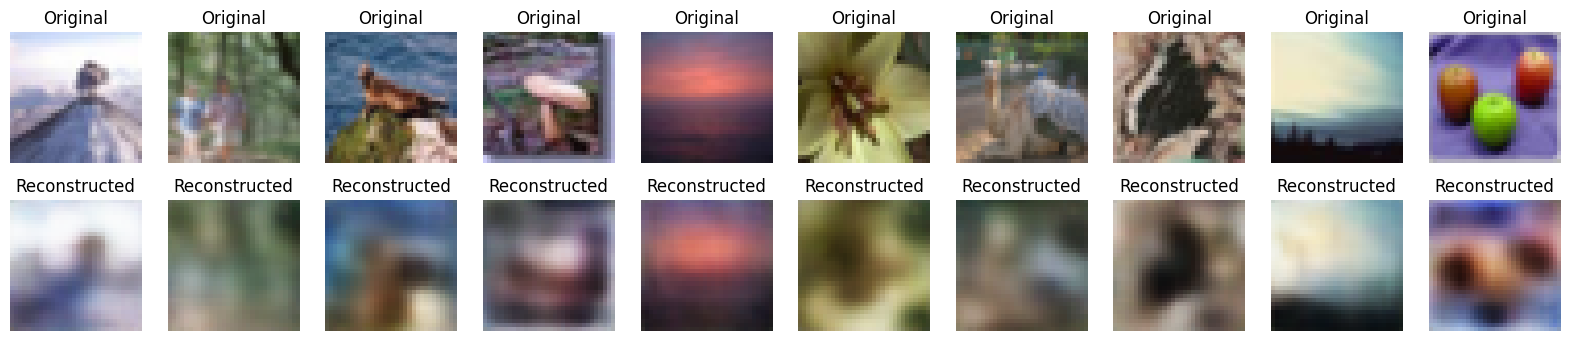

In [12]:
# Reconstruct images from the test set
decoded_imgs = autoencoder.predict(x_test)

# Visualize original and reconstructed images side by side
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

In [13]:
decoded_imgs.shape

(10000, 32, 32, 3)

In [14]:
x_test.shape

(10000, 32, 32, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

def extract_logits(images, batch_size=500):
    """
    Extrae los logits de las imágenes usando ResNet152V2.
    
    Parámetros:
    - batch_size: Tamaño de lote para evitar desbordamiento de memoria, para evitar que la GPU pare el proceso

    Retorna:
    - logits: Array de logits extraídos de ResNet152V2.
    """
    # if len(images.shape) != 4 or images.shape[-1] != 3:
    #     raise ValueError("Las imágenes deben tener la forma (N, H, W, 3)")

    resized_images = []
    for i in range(0, len(images), batch_size):
        batch = images[i : i + batch_size]
        batch_resized = tf.image.resize(batch, (224, 224)).numpy()
        resized_images.append(batch_resized)

    images_resized = np.concatenate(resized_images, axis=0)
    
    base_model = ResNet152V2(include_top=False, input_shape=(224, 224, 3), pooling="avg")
    model = Model(inputs=base_model.input, outputs=base_model.output)

    images_resized = preprocess_input(images_resized)

    logits_list = []
    for i in range(0, len(images_resized), batch_size):
        batch = images_resized[i : i + batch_size]
        logits_batch = model.predict(batch)
        logits_list.append(logits_batch)

    logits = np.concatenate(logits_list, axis=0)
    return logits

In [16]:
real_logits = extract_logits(x_test)
generated_logits = extract_logits(decoded_imgs)

16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 621ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 620ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 621ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 915ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 517ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 610ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 626ms/s

In [ ]:
from scipy.spatial.distance import cosine

def cosine_distance(features1, features2):
    distances = [cosine(f1, f2) for f1, f2 in zip(features1, features2)]
    return np.mean(distances)


Distancia Coseno: 0.01905372552573681


In [30]:
c_dist = cosine_distance(real_logits, generated_logits)
print(f'Distancia Coseno: {c_dist}')

Distancia Coseno: 0.01905372552573681


In [ ]:
from scipy.spatial.distance import jensenshannon
import numpy as np

def jensen_shannon_distance(features1, features2):
    jensen_shannon_distance = [jensenshannon(f1, f2) for f1, f2 in zip(features1, features2)]
    return np.mean(jensen_shannon_distance)


Distancia de Jensen-Shannon: 0.16185541450977325


In [29]:
js_distance = jensen_shannon_distance(real_logits, generated_logits)
print(f'Distancia de Jensen-Shannon: {js_distance}')

Distancia de Jensen-Shannon: 0.16185541450977325


In [27]:
def combined_similarity(features1, features2, alpha=0.5):
    """
    Combina la distancia de coseno y la distancia de Jensen-Shannon.
    
    Parámetros:
    - features1, features2: Arrays con los logits de las imágenes reales y reconstruidas.
    - alpha: Peso asignado a la distancia de coseno (0 <= alpha <= 1).
      La distancia de Jensen-Shannon tendrá un peso de (1 - alpha).
    
    Retorna:
    - Una métrica combinada que pondera ambas distancias.
    """
    cos_dist = cosine_distance(features1, features2)
    js_dist = jensen_shannon_distance(features1, features2)
    return alpha * cos_dist + (1 - alpha) * js_dist

In [28]:
comb_similarity = combined_similarity(features1=real_logits, features2=generated_logits, alpha=0.35)
print(f'Distancia de combined_similarity: {comb_similarity}')

Distancia de combined_similarity: 0.11187481880187988
